In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

Rode a célula abaixo (mude para "Code", por enquanto está "Raw") para capturar imagens.

# Projeto: Pedra-Papel-Tesoura

Neste projeto vocês devem construir um sistema que captura uma imagem da camera e diz se a imagem representa uma jogada de pedra, papel ou tesoura.

Projeto em duplas.

Entregável: Jupyter Notebook com a demonstração do sistema funcionando, e arquivo '.joblib' com o modelo treinado.

Entrega: 9/10, 23:59

Rubrica:

- I - Não entregou ou entregou nonsense.
- D - Funciona, mas com bugs menores.
- A - Funciona bem.

In [3]:
import os
import os.path
import re
from skimage.io import imread
from skimage.color import rgb2hsv

def read_images():
    data_dir = os.path.join(os.getcwd(), 'RPS')
    searcher = re.compile(r'^(.*)-(\d{1,2})\.png$')
    imgs = {}
    for name in os.listdir(data_dir):
        match = searcher.search(name)
        cat = match.group(1)
        num = int(match.group(2))
        img = imread(os.path.join(data_dir, name))
        
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        img_h = (img_hsv[:,:,0] >= 0) & (img_hsv[:,:,0] <= 50)
        img_s = (img_hsv[:,:,1] >= 100) & (img_hsv[:,:,1] <= 255)
        img_and = img_h & img_s
        
        if not cat in imgs:
            imgs[cat] = []
        imgs[cat].append(img_and)
    return imgs

imgs_per_cat = read_images()

paper: 8 images


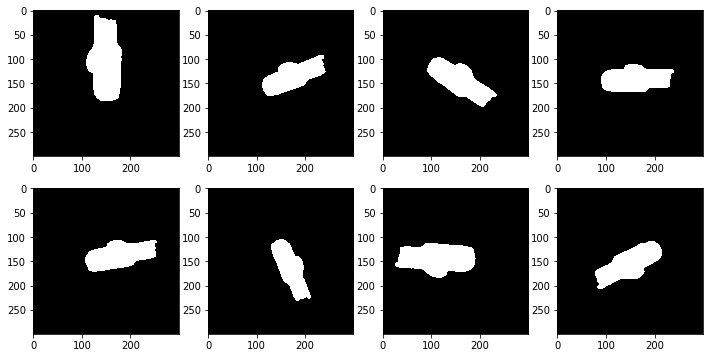

rock: 7 images


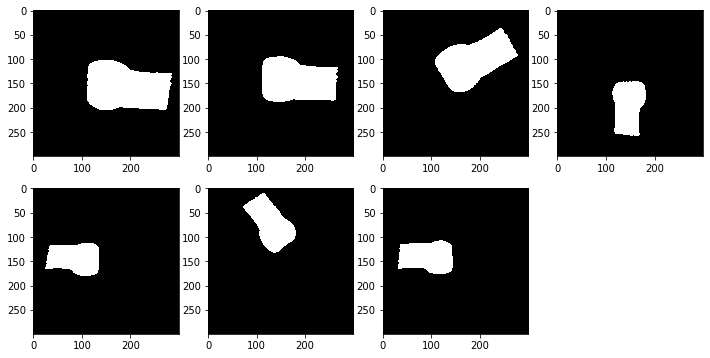

scissors: 8 images


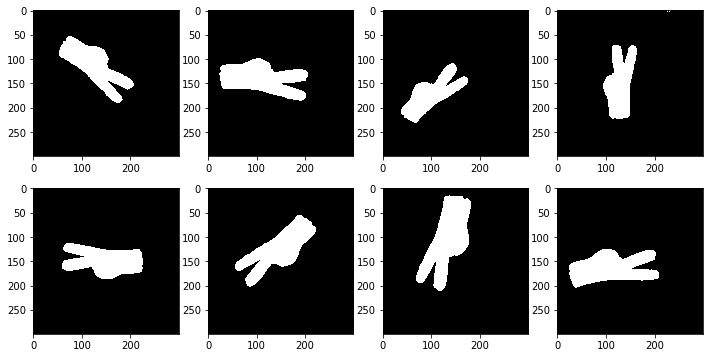

In [4]:
def show_images(imgs):
    C = 4
    N = len(imgs)
    R = (N - 1)//C + 1
    
    plt.figure(figsize=(C*3, R*3))
    for k, img in enumerate(imgs):
        plt.subplot(R, C, k+1)
        plt.imshow(img[100:400, 180:480], cmap='gray')
    plt.show()

for cat, imgs in imgs_per_cat.items():
    print(f'{cat}: {len(imgs)} images')
    show_images(imgs)

In [5]:
from skimage.measure import regionprops, perimeter

X = []
y = []

for cat, imgs in imgs_per_cat.items():
    for img in imgs:
        props = regionprops(img.astype(int))[0]
        eccentricity = props['eccentricity']
        hu_moments = props['moments_hu']
        area = props['area']
        perimeter = props['perimeter']
        if perimeter == 0.0:
            perimeter = 1.0
        compactness = 4.0*np.pi*area/perimeter
        feats = [eccentricity, compactness] + list(hu_moments)
        X.append(feats)
        y.append(cat)

c:\program files\python37\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
c:\program files\python37\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


In [33]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



## RandomForestClassifier

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf = RandomForestClassifier(n_estimators=100)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.5

In [36]:
# Salvando o modelo
import joblib

joblib.dump(clf, 'clf_model.joblib')

['clf_model.joblib']

In [37]:
# Lendo o modelo.
clf = joblib.load('clf_model.joblib')

Normalized confusion matrix
[[0.   0.   1.  ]
 [0.33 0.67 0.  ]
 [0.5  0.   0.5 ]]


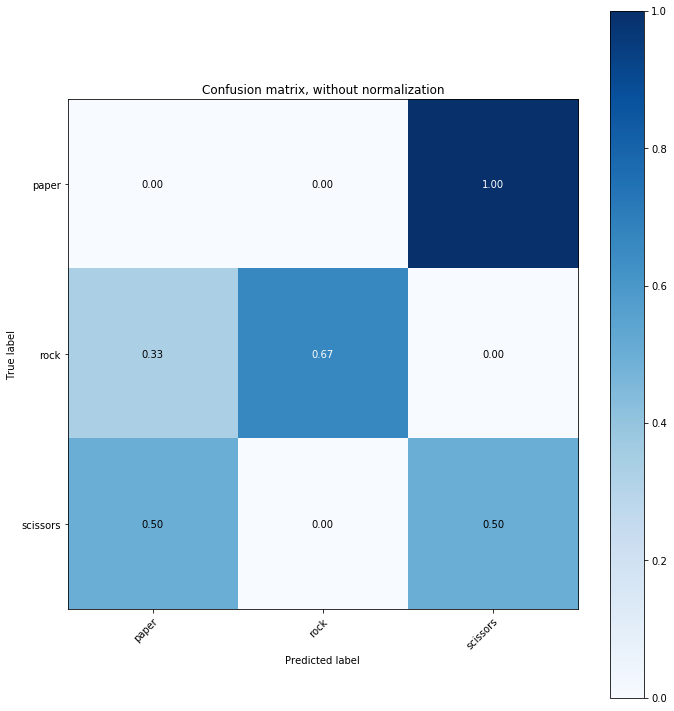

In [38]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=clf.classes_, normalize=True,
                      title='Confusion matrix, without normalization')

plt.show()

## KNeighborsClassifier

In [174]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

knn = KNeighborsClassifier(n_neighbors = 8)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy_score(y_test, y_pred)

0.3333333333333333

In [40]:
joblib.dump(knn, 'knn_model.joblib')

['knn_model.joblib']

In [41]:
# Lendo o modelo.
knn = joblib.load('knn_model.joblib')

Normalized confusion matrix
[[0.   1.   0.  ]
 [0.   0.67 0.33]
 [1.   0.   0.  ]]


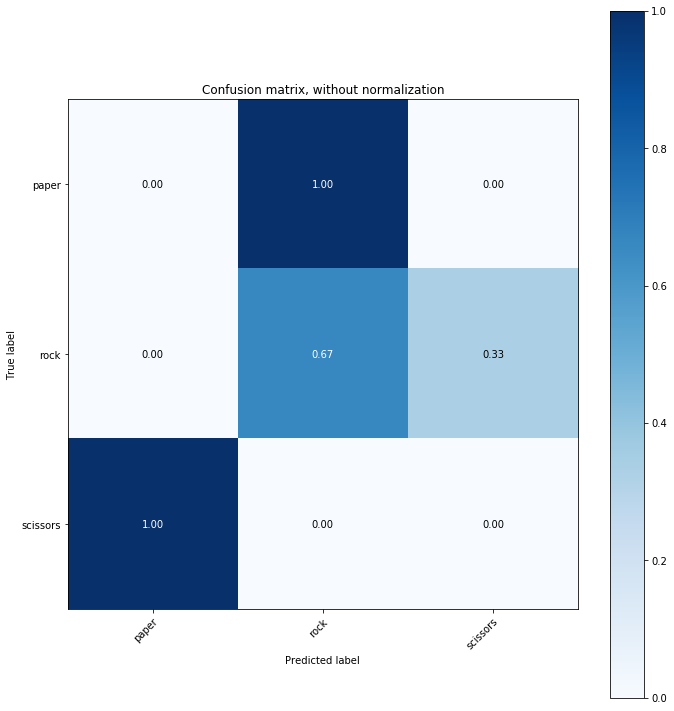

In [42]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=knn.classes_, normalize=True,
                      title='Confusion matrix, without normalization')

plt.show()

## GaussianNB

In [178]:
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

nb = GaussianNB()

nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

accuracy_score(y_test, y_pred)

0.6666666666666666

In [45]:
joblib.dump(nb, 'nb_model.joblib')

['nb_model.joblib']

In [46]:
# Lendo o modelo.
nb = joblib.load('nb_model.joblib')

Normalized confusion matrix
[[0.  1.  0. ]
 [0.  1.  0. ]
 [0.  0.5 0.5]]


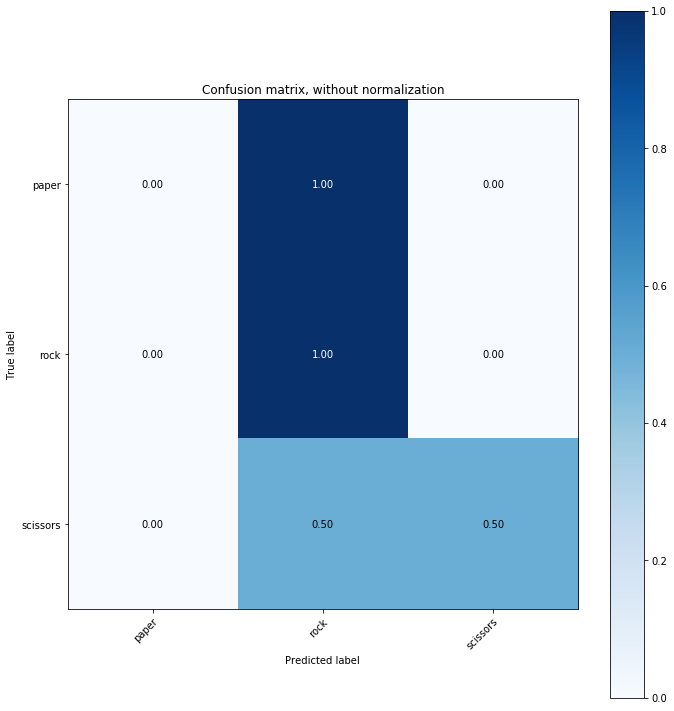

In [47]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=nb.classes_, normalize=True,
                      title='Confusion matrix, without normalization')

plt.show()

## MLPClassifier

In [194]:
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

pca = PCA(n_components=9)
xTrans = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(xTrans, y, test_size=0.25, random_state=42)

rede = MLPClassifier(hidden_layer_sizes=(100,100,100), activation="relu", alpha=0.001, learning_rate="adaptive")

rede.fit(X_train, y_train)
y_pred = rede.predict(X_test)

accuracy_score(y_test, y_pred)

c:\program files\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8333333333333334

In [195]:
joblib.dump(rede, 'MLP_model.joblib')

['MLP_model.joblib']

In [196]:
# Lendo o modelo.
rede = joblib.load('MLP_model.joblib')

Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


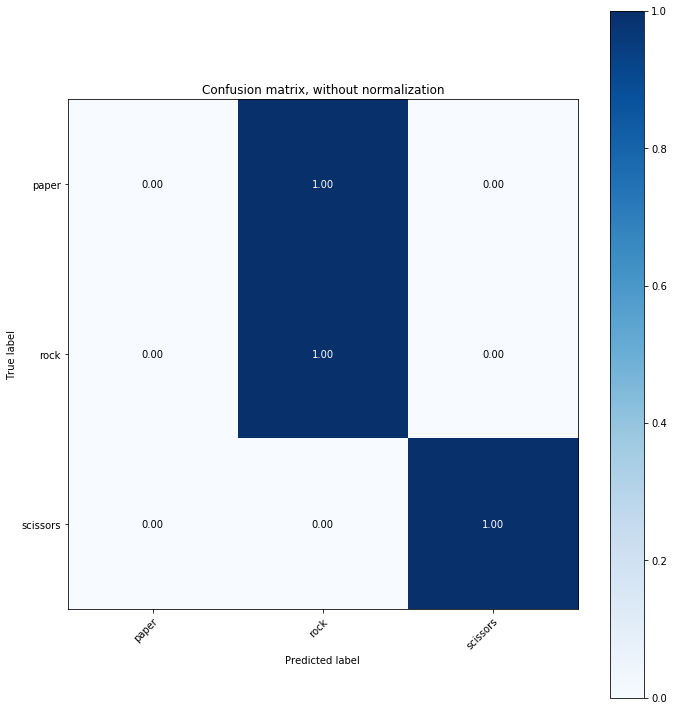

In [197]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=rede.classes_, normalize=True,
                      title='Confusion matrix, without normalization')

plt.show()

## SVC

In [186]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

svc = GaussianNB()

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

accuracy_score(y_test, y_pred)

0.6666666666666666

In [187]:
joblib.dump(rede, 'SVC_model.joblib')

['SVC_model.joblib']

In [188]:
svc = joblib.load('SVC_model.joblib')

Normalized confusion matrix
[[0.  1.  0. ]
 [0.  1.  0. ]
 [0.  0.5 0.5]]


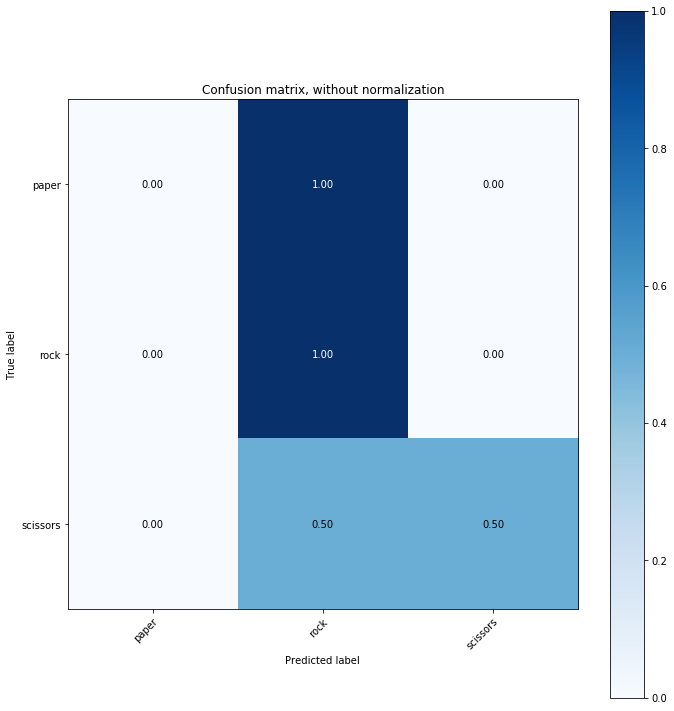

In [189]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=svc.classes_, normalize=True,
                      title='Confusion matrix, without normalization')

plt.show()